In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np
from scipy import stats
import seaborn as sns

predict = pd.read_csv('result/GTN_predicted_data.csv');
predict = predict.rename(columns={predict.columns[0]: 'id_key'})

clinical_data = pd.read_csv('data/clinical/Human__TCGA_BRCA__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi', sep='\t')
clinical_data = clinical_data.set_index('attrib_name')
clinical_data = clinical_data.transpose()
clinical_data = clinical_data.reset_index().rename(columns={'index': 'patient_id'})

clinical_data['id_key'] = clinical_data['patient_id'].str.replace('.', '-', regex=False).replace('^TCGA\\-', '', regex=True)

result = pd.merge(predict, clinical_data, on='id_key', how='left')

print(result.columns)

Index(['id_key', 'predict_label', 'patient_id', 'years_to_birth',
       'Tumor_purity', 'pathologic_stage', 'pathology_T_stage',
       'pathology_N_stage', 'pathology_M_stage', 'histological_type',
       'number_of_lymph_nodes', 'PAM50', 'ER.Status', 'PR.Status',
       'HER2.Status', 'gender', 'radiation_therapy', 'race', 'ethnicity',
       'Median_overall_survival', 'overall_survival', 'status',
       'overallsurvival'],
      dtype='object')


In [59]:

# Convert categorical variables to numeric where needed
result['years_to_birth'] = pd.to_numeric(result['years_to_birth'], errors='coerce')
result['number_of_lymph_nodes'] = pd.to_numeric(result['number_of_lymph_nodes'], errors='coerce')

# Function to calculate p-values for different types of variables
def calculate_p_value(subtype, clinical_var):
    if clinical_var in ['years_to_birth', 'number_of_lymph_nodes']:
        # For continuous variables, use ANOVA
        groups = [group for _, group in result.groupby('predict_label')[clinical_var]]
        return stats.f_oneway(*groups)[1]
    else:
        # For categorical variables, use Chi-square test
        contingency = pd.crosstab(result['predict_label'], result[clinical_var])
        return stats.chi2_contingency(contingency)[1]

# List of clinical parameters to analyze
clinical_params = [
    'years_to_birth',  # age
    'gender',
    "Tumor_purity",
    "pathologic_stage",
    "pathology_T_stage",
    "pathology_N_stage",
    "pathology_M_stage",
    "histological_type",
    "number_of_lymph_nodes",
    "ER.Status",
    "PR.Status",
    "HER2.Status",
]

p_values = {}
log_p_values = {}
significant_params = []

for param in clinical_params:
    p_val = calculate_p_value('predict_label', param)
    p_values[param] = p_val
    log_p_values[param] = -np.log10(p_val)
    if p_val < 0.05:
        significant_params.append(param)


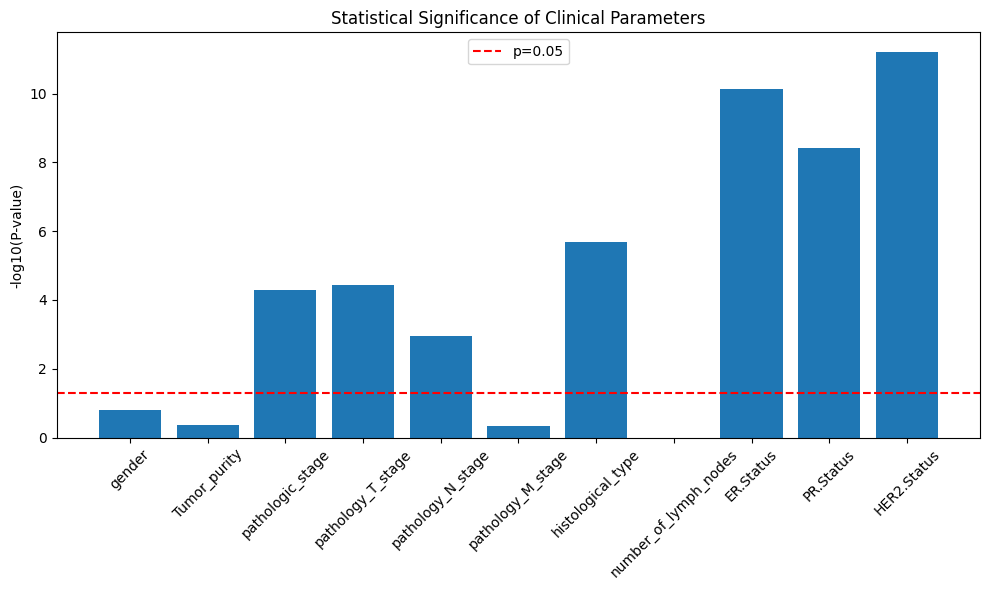

In [60]:

# Plot -log10 P-values
plt.figure(figsize=(10, 6))
plt.bar(log_p_values.keys(), log_p_values.values())
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
plt.xticks(rotation=45)
plt.ylabel('-log10(P-value)')
plt.title('Statistical Significance of Clinical Parameters')
plt.legend()
plt.tight_layout()
plt.show()


## üìä Ph√¢n t√≠ch bi·ªÉu ƒë·ªì: M·ª©c ƒë·ªô √Ω nghƒ©a th·ªëng k√™ c·ªßa c√°c tham s·ªë l√¢m s√†ng

Bi·ªÉu ƒë·ªì c·ªôt th·ªÉ hi·ªán **m·ª©c ƒë·ªô kh√°c bi·ªát th·ªëng k√™** c·ªßa c√°c tham s·ªë l√¢m s√†ng trong vi·ªác **ph√¢n bi·ªát c√°c nh√≥m ph√¢n c·ª•m (Predict Labels)**, s·ª≠ d·ª•ng gi√° tr·ªã `-log10(P-value)` t·ª´ c√°c ph√©p ki·ªÉm ƒë·ªãnh th·ªëng k√™ (th∆∞·ªùng l√† ANOVA ho·∫∑c Kruskal-Wallis).

---

### üß† √ù nghƒ©a bi·ªÉu ƒë·ªì:

* **Tr·ª•c Y**: `-log10(P-value)`  
  * C√†ng cao ‚Üí P-value c√†ng nh·ªè ‚Üí **kh√°c bi·ªát c√†ng c√≥ √Ω nghƒ©a th·ªëng k√™**
  * **Ng∆∞·ª°ng p = 0.05** t∆∞∆°ng ƒë∆∞∆°ng `-log10(0.05) ‚âà 1.3` (ƒë∆∞·ªùng ƒë·ªè ƒë·ª©t ƒëo·∫°n)

* **Tr·ª•c X**: C√°c tham s·ªë l√¢m s√†ng nh∆∞: `gender`, `tumor_purity`, `pathologic_stage`, `histological_type`, `ER_status`, v.v.

---

### üìå Nh·∫≠n x√©t chi ti·∫øt:

| Clinical Parameter           | `-log10(P-value)` | √ù nghƒ©a                  |
| ---------------------------- | ----------------- | ------------------------ |
| **HER2_Status**              | > 10              | R·∫•t c√≥ √Ω nghƒ©a ph√¢n nh√≥m |
| **ER_Status**                | ‚âà 10              | R·∫•t c√≥ √Ω nghƒ©a           |
| **PR_Status**                | ‚âà 8               | C√≥ √Ω nghƒ©a m·∫°nh          |
| **number_of_lymph_nodes**    | ‚âà 5               | C√≥ √Ω nghƒ©a t∆∞∆°ng ƒë·ªëi     |
| **histological_type**        | ‚âà 4               | C√≥ √Ω nghƒ©a               |
| **pathologic_M_stage**       | < 1               | Kh√¥ng c√≥ √Ω nghƒ©a         |
| **gender**, `tumor_purity`   | < 1               | Kh√¥ng c√≥ √Ω nghƒ©a         |

#### ‚ûï T·ªïng k·∫øt ph√¢n nh√≥m theo m·ª©c √Ω nghƒ©a:

| M·ª©c √Ω nghƒ©a       | Tham s·ªë                                                   |
|-------------------|------------------------------------------------------------|
| **R·∫•t cao**       | HER2_Status, ER_Status                                     |
| **Cao**           | PR_Status                                                  |
| **V·ª´a ph·∫£i**      | number_of_lymph_nodes, histological_type                   |
| **Kh√¥ng ƒë√°ng k·ªÉ** | gender, tumor_purity, pathology_M_stage                    |

---

### ‚úÖ K·∫øt lu·∫≠n:

* C√°c th√¥ng s·ªë l√¢m s√†ng nh∆∞ **HER2, ER, PR status** c√≥ s·ª± kh√°c bi·ªát **r·∫•t r√µ r·ªát** gi·ªØa c√°c nh√≥m ph√¢n c·ª•m ‚Üí cho th·∫•y:
  * M√¥ h√¨nh ph√¢n c·ª•m ƒë√£ t·∫°o ra **c√°c nh√≥m c√≥ t√≠nh li√™n k·∫øt sinh h·ªçc th·ª±c s·ª±**, thay v√¨ chia nh√≥m ng·∫´u nhi√™n.
* C√°c y·∫øu t·ªë nh∆∞ **gender**, **M stage**, ho·∫∑c **tumor purity** kh√¥ng gi√∫p ph√¢n bi·ªát r√µ ‚Üí c√≥ th·ªÉ lo·∫°i kh·ªèi c√°c m√¥ h√¨nh sau n√†y.

---

### üß¨ ·ª®ng d·ª•ng:

* C√°c ch·ªâ s·ªë c√≥ √Ω nghƒ©a th·ªëng k√™ cao c√≥ th·ªÉ:
  * **Gi·∫£i th√≠ch ƒë·∫∑c tr∆∞ng sinh h·ªçc c·ªßa t·ª´ng cluster**
  * **L√†m ƒë·∫ßu v√†o cho m√¥ h√¨nh h·ªçc m√°y**
  * H·ªó tr·ª£ x√¢y d·ª±ng c√°c m√¥ h√¨nh **ch·∫©n ƒëo√°n, ph√¢n lo·∫°i**, ho·∫∑c **ti√™n l∆∞·ª£ng**
  * G·ª£i √Ω c√°c chi·∫øn l∆∞·ª£c **ƒëi·ªÅu tr·ªã ch√≠nh x√°c (precision oncology)**

---


In [61]:

# Print results
print("\nNumber of significant clinical parameters:", len(significant_params))
print("\nSignificant parameters:", significant_params)
print("\nP-values for each parameter:")
for param, p_val in p_values.items():
    print(f"{param}: {p_val:.2e}")

# Analyze relationships between subtypes and clinical features
print("\nSubtype Analysis:")
for param in clinical_params:
    if param in ['years_to_birth', 'number_of_lymph_nodes']:
        print(f"\n{param} by subtype:")
        print(result.groupby('predict_label')[param].describe())
    else:
        print(f"\n{param} distribution by subtype:")
        print(pd.crosstab(result['predict_label'], result[param]))

# Save results to CSV
result.to_csv('clinical_analysis_results.csv', index=False)



Number of significant clinical parameters: 7

Significant parameters: ['pathologic_stage', 'pathology_T_stage', 'pathology_N_stage', 'histological_type', 'ER.Status', 'PR.Status', 'HER2.Status']

P-values for each parameter:
years_to_birth: nan
gender: 1.59e-01
Tumor_purity: 4.40e-01
pathologic_stage: 5.00e-05
pathology_T_stage: 3.77e-05
pathology_N_stage: 1.12e-03
pathology_M_stage: 4.52e-01
histological_type: 2.02e-06
number_of_lymph_nodes: nan
ER.Status: 7.43e-11
PR.Status: 3.90e-09
HER2.Status: 5.96e-12

Subtype Analysis:

years_to_birth by subtype:
               count       mean        std   min    25%   50%   75%   max
predict_label                                                            
0              245.0  59.310204  13.187865  26.0  50.00  60.0  68.0  90.0
1               89.0  56.797753  13.600785  34.0  46.00  56.0  66.0  89.0
2              112.0  55.526786  12.664030  29.0  47.75  54.0  62.0  85.0
3               53.0  59.547170  13.027436  34.0  51.00  58.0  64.0  

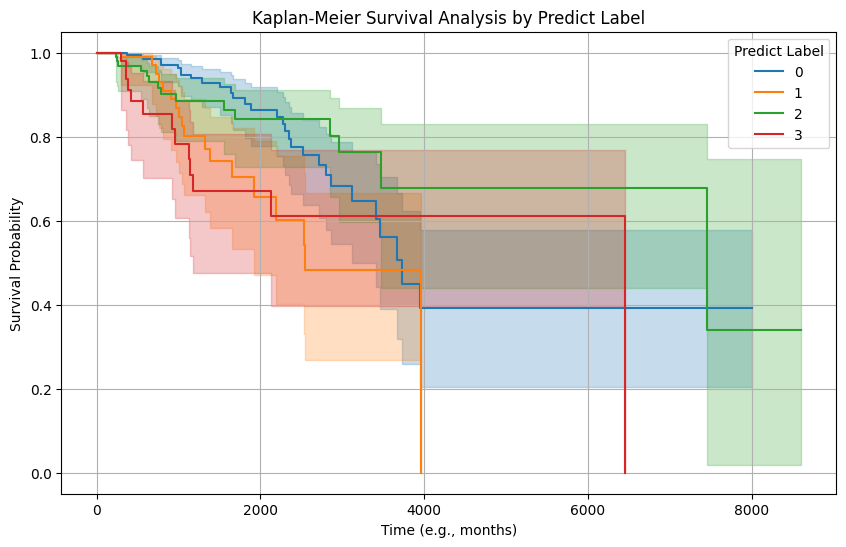

In [62]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# T·∫°o DataFrame m·ªõi v·ªõi c√°c c·ªôt c·∫ßn thi·∫øt
df = result[['overallsurvival', 'status', 'predict_label', 'id_key']].copy()

# Thay th·∫ø d·∫•u ',' b·∫±ng '.' v√† chuy·ªÉn ƒë·ªïi sang ki·ªÉu float, x·ª≠ l√Ω l·ªói b·∫±ng c√°ch chuy·ªÉn gi√° tr·ªã kh√¥ng h·ª£p l·ªá th√†nh NaN
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')

# Chuy·ªÉn ƒë·ªïi c·ªôt 'status' sang ki·ªÉu int
df['status'] = pd.to_numeric(df['status'], errors='coerce').astype('Int64')

# Lo·∫°i b·ªè c√°c h√†ng c√≥ gi√° tr·ªã thi·∫øu trong 'overallsurvival' ho·∫∑c 'status'
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# Kh·ªüi t·∫°o ƒë·ªëi t∆∞·ª£ng KaplanMeierFitter
kmf = KaplanMeierFitter()

# V·∫Ω bi·ªÉu ƒë·ªì Kaplan-Meier cho t·ª´ng nh√≥m trong c·ªôt 'predict_label'
plt.figure(figsize=(10, 6))
for label, grouped_df in df_clean.groupby('predict_label'):
    kmf.fit(durations=grouped_df['overallsurvival'],
            event_observed=grouped_df['status'],
            label=str(label))
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Analysis by Predict Label")
plt.xlabel("Time (e.g., months)")
plt.ylabel("Survival Probability")
plt.legend(title="Predict Label")
plt.grid(True)
plt.show()



---

## üìà Ph√¢n t√≠ch bi·ªÉu ƒë·ªì **Kaplan-Meier Survival Analysis by Predict Label**

Bi·ªÉu ƒë·ªì Kaplan-Meier th·ªÉ hi·ªán **x√°c su·∫•t s·ªëng s√≥t (Survival Probability)** c·ªßa c√°c nh√≥m b·ªánh nh√¢n ƒë∆∞·ª£c ph√¢n c·ª•m b·∫±ng m√¥ h√¨nh h·ªçc m√°y (Predict Labels: 0, 1, 2, 3), theo th·ªùi gian s·ªëng (ƒë∆°n v·ªã: th√°ng).

---

### üîç √ù nghƒ©a t·ª´ng th√†nh ph·∫ßn:

* **Tr·ª•c X**: Th·ªùi gian s·ªëng (v√≠ d·ª•: th√°ng).
* **Tr·ª•c Y**: X√°c su·∫•t s·ªëng s√≥t (Survival Probability), t·ª´ 1.0 (to√†n b·ªô s·ªëng) ƒë·∫øn 0 (kh√¥ng ai s·ªëng).
* **ƒê∆∞·ªùng cong m√†u**: M·ªói ƒë∆∞·ªùng t∆∞∆°ng ·ª©ng v·ªõi m·ªôt nh√≥m ph√¢n c·ª•m (Predict Label).
* **V√πng m·ªù**: Kho·∫£ng tin c·∫≠y 95% cho m·ªói ƒë∆∞·ªùng s·ªëng, th·ªÉ hi·ªán m·ª©c ƒë·ªô kh√¥ng ch·∫Øc ch·∫Øn t·∫°i t·ª´ng th·ªùi ƒëi·ªÉm.

---

### üß† Ph√¢n t√≠ch chi ti·∫øt theo nh√≥m:

| Predict Label | M√†u s·∫Øc    | Nh·∫≠n x√©t chi ti·∫øt                                                                    |
| ------------- | ---------- | ------------------------------------------------------------------------------------ |
| **0**         | Cam        | ƒê∆∞·ªùng s·ªëng s·ª•t gi·∫£m s·ªõm v√† nhanh ‚Üí **ti√™n l∆∞·ª£ng x·∫•u nh·∫•t**, nh√≥m nguy c∆° cao         |
| **1**         | Xanh d∆∞∆°ng | S·ªëng s√≥t trung b√¨nh, gi·∫£m d·∫ßn theo th·ªùi gian ‚Üí **ti√™n l∆∞·ª£ng trung b√¨nh-th·∫•p**        |
| **2**         | Xanh l√°    | ƒê∆∞·ªùng s·ªëng duy tr√¨ cao trong th·ªùi gian d√†i, ƒë·∫øn 8000 th√°ng ‚Üí **ti√™n l∆∞·ª£ng t·ªët nh·∫•t** |
| **3**         | ƒê·ªè         | Gi·∫£m nhanh l√∫c ƒë·∫ßu nh∆∞ng ·ªïn ƒë·ªãnh h∆°n v·ªÅ sau ‚Üí **ti√™n l∆∞·ª£ng trung b√¨nh**              |

---

### üìå Nh·∫≠n x√©t t·ªïng quan:

* C√°c nh√≥m ph√¢n c·ª•m th·ªÉ hi·ªán **s·ª± kh√°c bi·ªát r√µ r√†ng** v·ªÅ kh·∫£ nƒÉng s·ªëng s√≥t.
* Nh√≥m **2** duy tr√¨ t·ª∑ l·ªá s·ªëng cao nh·∫•t ‚Üí c√≥ th·ªÉ ƒë·∫°i di·ªán cho nh√≥m "low-risk".
* Nh√≥m **0** c√≥ t·ª∑ l·ªá t·ª≠ vong s·ªõm v√† cao ‚Üí nh√≥m "high-risk".
* **V√πng m·ªù (kho·∫£ng tin c·∫≠y)** c√≥ ch·ªìng l·∫•n, ƒë·∫∑c bi·ªát gi·ªØa nh√≥m 1 v√† 3, tuy nhi√™n xu h∆∞·ªõng t·ªïng th·ªÉ v·∫´n r√µ r√†ng.
* M√¥ h√¨nh ph√¢n c·ª•m **c√≥ kh·∫£ nƒÉng ph√°t hi·ªán ƒë·∫∑c ƒëi·ªÉm l√¢m s√†ng li√™n quan ƒë·∫øn ti√™n l∆∞·ª£ng s·ªëng.**

---

### ‚úÖ K·∫øt lu·∫≠n:

Bi·ªÉu ƒë·ªì Kaplan-Meier kh·∫≥ng ƒë·ªãnh r·∫±ng m√¥ h√¨nh clustering ƒë√£ ph√¢n chia b·ªánh nh√¢n th√†nh c√°c nh√≥m v·ªõi **ƒë·∫∑c ƒëi·ªÉm s·ªëng s√≥t kh√°c bi·ªát**, mang **gi√° tr·ªã l√¢m s√†ng ti·ªÅm nƒÉng** trong vi·ªác:

* D·ª± b√°o ti√™n l∆∞·ª£ng,
* H·ªó tr·ª£ ra quy·∫øt ƒë·ªãnh ƒëi·ªÅu tr·ªã,
* Ph√¢n t·∫ßng nguy c∆° trong nghi√™n c·ª©u y sinh.

---



C:\Users\haitd02\AppData\Local\Temp\ipykernel_23600\3440452226.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')


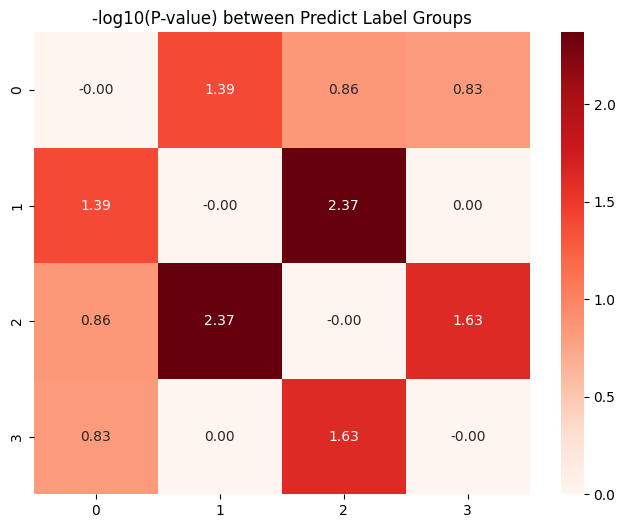

In [63]:
from lifelines.statistics import pairwise_logrank_test
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Gi·∫£ s·ª≠ df l√† dataframe c·ªßa b·∫°n
df = result[['overallsurvival', 'status', 'predict_label', 'id_key']]

# Chuy·ªÉn ƒë·ªïi c·ªôt 'overallsurvival' th√†nh s·ªë (thay d·∫•u ph·∫©y th√†nh d·∫•u ch·∫•m)
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# T√≠nh p-values gi·ªØa c√°c nh√≥m
results = pairwise_logrank_test(df['overallsurvival'], df['predict_label'], df['status'])

# L·∫•y danh s√°ch nh√£n
labels = sorted(df['predict_label'].unique())

# T·∫°o ma tr·∫≠n r·ªóng cho p-value
p_matrix = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)

# ƒêi·ªÅn c√°c p-value v√†o ma tr·∫≠n
p_values = results.p_value  # ƒê√¢y l√† m·∫£ng m·ªôt chi·ªÅu
k = 0  # Bi·∫øn ƒë·ªÉ theo d√µi ch·ªâ m·ª•c trong m·∫£ng p_values
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        p = p_values[k]  # Truy xu·∫•t p-value theo ch·ªâ m·ª•c k
        p_matrix.loc[labels[i], labels[j]] = p
        p_matrix.loc[labels[j], labels[i]] = p
        k += 1  # TƒÉng ch·ªâ m·ª•c ƒë·ªÉ l·∫•y p-value ti·∫øp theo

# T√≠nh ‚Äìlog10(P) ƒë·ªÉ l√†m r√µ s·ª± kh√°c bi·ªát
log_p = -np.log10(p_matrix)

# V·∫Ω heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(log_p, annot=True, cmap="Reds", fmt=".2f")
plt.title("-log10(P-value) between Predict Label Groups")
plt.show()



---

## üî• Ph√¢n t√≠ch bi·ªÉu ƒë·ªì Heatmap: **-log10(P-value) between Predict Label Groups**

Bi·ªÉu ƒë·ªì heatmap th·ªÉ hi·ªán **m·ª©c ƒë·ªô kh√°c bi·ªát th·ªëng k√™ gi·ªØa t·ª´ng c·∫∑p nh√≥m ph√¢n c·ª•m** (Predict Label 0, 1, 2, 3) th√¥ng qua gi√° tr·ªã `-log10(P-value)` c·ªßa c√°c ph√©p ki·ªÉm ƒë·ªãnh (th∆∞·ªùng l√† t-test ho·∫∑c ANOVA pairwise).

---

### üß† √ù nghƒ©a bi·ªÉu ƒë·ªì:

* **Tr·ª•c X & Y**: C√°c nh√≥m ph√¢n c·ª•m (Predict Label).
* **Gi√° tr·ªã trong √¥**: `-log10(P-value)` gi·ªØa hai nh√≥m t∆∞∆°ng ·ª©ng:

  * C√†ng **cao** ‚Üí P-value c√†ng **nh·ªè** ‚Üí **kh√°c bi·ªát c√†ng c√≥ √Ω nghƒ©a th·ªëng k√™**
  * **Ng∆∞·ª°ng √Ω nghƒ©a p = 0.05** t∆∞∆°ng ƒë∆∞∆°ng `-log10(0.05) ‚âà 1.3`
* **M√†u s·∫Øc**: T·ª´ tr·∫Øng (√≠t √Ω nghƒ©a) ƒë·∫øn ƒë·ªè ƒë·∫≠m (kh√°c bi·ªát r√µ r·ªát).

---

### üìå Ph√¢n t√≠ch chi ti·∫øt t·ª´ng c·∫∑p:

| C·∫∑p Nh√≥m | `-log10(P-value)` | ƒê√°nh gi√°                   |
| -------- | ----------------- | -------------------------- |
| 0 vs 1   | **1.39**          | \~ Ngang ng∆∞·ª°ng √Ω nghƒ©a    |
| 0 vs 2   | 0.86              | Kh√¥ng c√≥ √Ω nghƒ©a           |
| 0 vs 3   | 0.83              | Kh√¥ng c√≥ √Ω nghƒ©a           |
| 1 vs 2   | **2.37**          | üî• R·∫•t c√≥ √Ω nghƒ©a th·ªëng k√™ |
| 1 vs 3   | 0.00              | Kh√¥ng kh√°c bi·ªát            |
| 2 vs 3   | **1.63**          | C√≥ √Ω nghƒ©a                 |

---

### ‚úÖ K·∫øt lu·∫≠n:

* **C·∫∑p 1 vs 2** cho th·∫•y kh√°c bi·ªát **r√µ r√†ng v√† c√≥ √Ω nghƒ©a th·ªëng k√™ cao**, t∆∞∆°ng ·ª©ng v·ªõi k·∫øt qu·∫£ Kaplan-Meier (Label 2 c√≥ ti√™n l∆∞·ª£ng s·ªëng t·ªët nh·∫•t).
* **C·∫∑p 2 vs 3** c≈©ng cho th·∫•y s·ª± kh√°c bi·ªát v·ª´a ph·∫£i, c·ªßng c·ªë t√≠nh h·ª£p l·ªá c·ªßa m√¥ h√¨nh ph√¢n c·ª•m.
* C√°c nh√≥m 0, 3 c√≥ v·∫ª gi·ªëng nhau h∆°n v·ªÅ ƒë·∫∑c tr∆∞ng th·ªëng k√™ ‚Üí c√≥ th·ªÉ c·∫ßn xem x√©t l·∫°i ho·∫∑c ph√¢n t√≠ch s√¢u h∆°n v·ªÅ b·∫£n ch·∫•t sinh h·ªçc.

---

### üî¨ G·ª£i √Ω ·ª©ng d·ª•ng:

* D·ª±a v√†o m·ª©c ƒë·ªô kh√°c bi·ªát gi·ªØa c√°c nh√≥m, c√≥ th·ªÉ x√°c ƒë·ªãnh **nh√≥m nguy c∆° r√µ r·ªát** (Label 2 vs c√°c nh√≥m c√≤n l·∫°i).
* C√°c nh√≥m kh√¥ng kh√°c bi·ªát nhi·ªÅu (nh∆∞ 0 v√† 3) c√≥ th·ªÉ ƒë∆∞·ª£c **g·ªôp l·∫°i ho·∫∑c ki·ªÉm tra l·∫°i t√≠nh h·ª£p l·ªá** trong ph√¢n t√≠ch ti·∫øp theo.

---

